In [1]:
## CREDIT RISK PROJECT 
# Bivariate spread-loss model

In [2]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

## STEP 1 - DATA

In [3]:
# Step 1: Understand the data structure
# Load all tranche sheets into a dictionary for inspection
file_path = '/Users/anushreeminase/Downloads/CDX.NA.IG39 Tranche data.xlsx'
excel_file = pd.ExcelFile(file_path)


In [4]:
tranche_data = {}
# Load each tranche sheet into a DataFrame
for sheet_name in excel_file.sheet_names:
    tranche_data[sheet_name] = excel_file.parse(sheet_name)

# Display basic information about each tranche sheet
tranche_summary = {
    sheet_name: {
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Column Names": df.columns.tolist(),
        "Sample Data": df.head().to_dict(orient="records")
    }
    for sheet_name, df in tranche_data.items()
}

In [6]:
# Step 2: Clean the tranche data for analysis

# Function to clean a single tranche DataFrame
def clean_tranche_data(df):
        
    df = df.copy()

    # Rename columns for clarity
    df.columns = ['Day', 'Date', 'Spread']
    
    # Drop rows with missing or invalid data
    df = df.dropna()
    
    # Ensure 'Date' is properly formatted as datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Drop rows where 'Date' could not be parsed
    df = df.dropna(subset=['Date'])
    
    # Ensure 'Spread' is numeric
    df['Spread'] = pd.to_numeric(df['Spread'], errors='coerce')
    
    # Drop rows with invalid 'Spread' values
    df = df.dropna(subset=['Spread'])
    
    # Sort by date
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    return df

In [7]:
# Separate CDX_quote from tranche_data
cdx_quote_data = tranche_data.pop('CDX_quote')  # Extract CDX_quote

# Clean CDX_quote data (drop NaN rows, reset index, and rename columns if necessary)
cdx_quote_data_cleaned = clean_tranche_data(cdx_quote_data)



In [8]:

# Clean all tranche sheets
cleaned_tranche_data = {sheet_name: clean_tranche_data(df) for sheet_name, df in tranche_data.items()}

# Display the cleaned data for one tranche as a sample
sample_cleaned_tranche = cleaned_tranche_data['0-3%']
sample_cleaned_tranche.head()

,Day,Date,Spread
0,Tu,2022-10-18,49.730
1,We,2022-10-19,49.692
2,Th,2022-10-20,49.681
3,Fr,2022-10-21,50.584
4,Mo,2022-10-24,48.750


In [9]:
# FILTER FOR 6 MONTHS:

from datetime import timedelta

# Filter cleaned_tranche_data for the latest 6 months
filtered_tranche_data = {}

for tranche, data in cleaned_tranche_data.items():
    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Get the latest date in the tranche data
    latest_date = data['Date'].max()
    
    # Calculate cutoff date for the last 6 months
    cutoff_date = latest_date - timedelta(days=6 * 30)  # Approximation for 6 months
    
    # Filter data for the last 6 months
    filtered_data = data[data['Date'] >= cutoff_date]
    
    # Store the filtered data
    filtered_tranche_data[tranche] = filtered_data

# Display filtered data
for tranche, data in filtered_tranche_data.items():
    print(f"{tranche} Tranche (Last 6 Months):")
    print(data.head())
    print()


0-3% Tranche (Last 6 Months):
    Day       Date  Spread
403  Fr 2024-05-03  19.022
404  Mo 2024-05-06  18.540
405  Tu 2024-05-07  18.506
406  We 2024-05-08  18.501
407  Th 2024-05-09  18.496

3-7% Tranche (Last 6 Months):
    Day       Date  Spread
419  Fr 2024-05-03   0.628
420  Mo 2024-05-06   0.501
421  Tu 2024-05-07   0.467
422  We 2024-05-08   0.478
423  Th 2024-05-09   0.475

7-15% Tranche (Last 6 Months):
    Day       Date  Spread
403  Fr 2024-05-03  -2.110
404  Mo 2024-05-06  -2.163
405  Tu 2024-05-07  -2.169
406  We 2024-05-08  -2.164
407  Th 2024-05-09  -2.163

15-100% Tranche (Last 6 Months):
    Day       Date  Spread
419  Fr 2024-05-03  -3.022
420  Mo 2024-05-06  -3.034
421  Tu 2024-05-07  -3.025
422  We 2024-05-08  -3.027
423  Th 2024-05-09  -3.018



In [10]:
cleaned_tranche_data = filtered_tranche_data

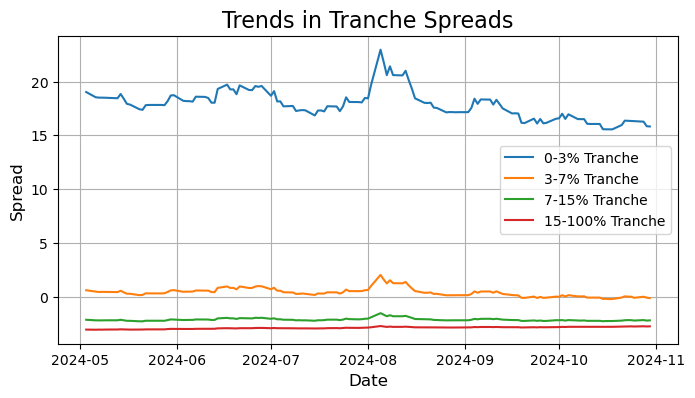

In [11]:
# Function to visualize trends for all tranches on a single plot
def visualize_trends_together(cleaned_data):
    plt.figure(figsize=(8,4))
    
    # Plot trends for all tranches
    for tranche, data in cleaned_data.items():
        if 'Spread' in data.columns and 'Date' in data.columns:
            plt.plot(data['Date'], data['Spread'], label=f'{tranche} Tranche')
    
    # Add titles, labels, and legend
    plt.title('Trends in Tranche Spreads', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Spread', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize all cleaned tranche data trends together
visualize_trends_together(cleaned_tranche_data)


Key observations:

- Distinct Spread Levels:
The spreads decrease as the tranche risk increases (e.g., 0-3% tranche has the highest spreads, while 15-100% has the lowest).
- Similar Fluctuation Patterns:
All tranches show similar patterns over time, reflecting market-wide credit risk dynamics.
- Volatility Differences:
Lower-risk tranches (e.g., 0-3%) exhibit greater spread fluctuations compared to higher-risk tranches (e.g., 15-100%).

## STEP 2 - MODEL FRAMEWORK

In [12]:
# Define parameters
n = 125  # Total number of entities in the portfolio
kappa = 0.1  # Mean-reversion speed
sigma = 0.2  # Volatility of Y_t
time_steps = 1000  # Number of time steps for simulation
dt = 1 / 252  # Time increment (daily, assuming 252 trading days)
initial_Y = 0.05  # Initial value of Y_t

# Initialize arrays for simulation
Y_t = np.zeros(time_steps)
Y_t[0] = initial_Y  # Initial value

# Simulate Spread Volatility (Y_t) using Euler-Maruyama
for t in range(1, time_steps):
    dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
    Y_t[t] = Y_t[t - 1] * np.exp(-kappa * np.log(Y_t[t - 1]) * dt + sigma * dW)


## STEP 3 - CALIBRATION

In [13]:
# sample with one tranche [0,0.03]

In [14]:
# Function to calculate pricing error for a given set of b_k coefficients
def pricing_error(b_k, spreads, attachment_points):
    """
    Calculate pricing error for a given set of b_k coefficients.
    Args:
        b_k (list): Coefficients to be calibrated.
        spreads (np.array): Observed tranche spreads.
        attachment_points (list): List of tranche attachment-detachment points.
    Returns:
        float: Sum of squared pricing errors.
    """
    n = 125  # Total number of entities in the portfolio (example)
    N_t = np.arange(len(b_k))  # Simulated number of defaults (example)
    Y_t = spreads.mean()  # Use mean spread as a proxy for Y_t
    
    # Calculate default intensity (lambda_t) using b_k
    lambda_t = np.array([
        Y_t * (n - len(N_t)) * sum(b_k[:len(N_t)]) for _ in spreads
    ])
    
    # Error is the difference between simulated and observed spreads
    error = np.sum((lambda_t - spreads) ** 2)
    return error


In [16]:
# Estimation of kappa (κ) and sigma (σ) using mean-reversion characteristics
def estimate_mean_reversion_params(spreads, dt=1/252):
    """
    Estimate kappa (mean-reversion speed) and sigma (volatility) from spread data.
    Args:
        spreads (np.array): Spread time series.
        dt (float): Time step, default is daily (1/252).
    Returns:
        tuple: Estimated kappa and sigma.
    """
    # Filter positive spreads to avoid log issues
    spreads = spreads[spreads > 0]
    if len(spreads) < 2:
        print("Insufficient positive spread data for estimation.")
        return None, None
    
    log_spreads = np.log(spreads)
    delta_log_spreads = np.diff(log_spreads)
    mean_reversion_speed = -np.mean(delta_log_spreads / log_spreads[:-1]) / dt
    volatility = np.std(delta_log_spreads) / np.sqrt(dt)
    return mean_reversion_speed, volatility

In [20]:
# iteratevely caliberate through all tranches 

In [17]:

# attachment points for all tranches
attachment_points_dict = {
    '0-3%': [0, 0.03],
    '3-7%': [0.03, 0.07],
    '7-15%': [0.07, 0.15],
    '15-100%': [0.15, 1.00]
}


In [19]:
# UPDATED METHOD -

In [18]:
def adjust_spreads(spreads):
    offset = abs(min(spreads)) + 1 if min(spreads) <= 0 else 0
    return spreads + offset

def log_transform_spreads(spreads):
    return np.log(np.abs(spreads) + 1)  # Add 1 to avoid log(0)

def normalize_spreads(spreads):
    min_val = spreads.min()
    max_val = spreads.max()
    return (spreads - min_val) / (max_val - min_val)


In [19]:
def calibrate_all_tranches_with_adjustments(tranche_data, attachment_points_dict, transform_method='normalize'):
    """
    Calibrate the b_k, kappa, and sigma for all tranches with spread adjustments.
    Args:
        tranche_data (dict): Dictionary of tranche names and their cleaned DataFrames.
        attachment_points_dict (dict): Dictionary of tranche names and attachment/detachment points.
        transform_method (str): Method to adjust spreads ('offset', 'log', 'normalize').
    Returns:
        dict: Calibration results with b_k, kappa, and sigma for each tranche.
    """
    # Define transformation methods
    transform_methods = {
        'offset': adjust_spreads,
        'log': log_transform_spreads,
        'normalize': normalize_spreads
    }
    
    transform_func = transform_methods.get(transform_method, log_transform_spreads)
    results = {}
    
    for tranche_name, data in tranche_data.items():
        if 'Spread' in data.columns:
            spreads = data['Spread'].values
            
            # Adjust spreads based on the selected method
            normalized_spreads = transform_func(spreads)
            
            # Calibrate b_k
            attachment_points = attachment_points_dict.get(tranche_name, [0, 0.03])
            initial_b_k = [0.01] * len(attachment_points)
            result = minimize(pricing_error, x0=initial_b_k, args=(normalized_spreads, attachment_points), method='Nelder-Mead')
            calibrated_b_k = result.x
            
            # Estimate kappa and sigma
            kappa, sigma = estimate_mean_reversion_params(normalized_spreads)
            
            # Store results
            results[tranche_name] = {
                'b_k': calibrated_b_k,
                'kappa': kappa,
                'sigma': sigma
            }
    return results

# Example calibration using offset adjustment
calibration_results_adjusted = calibrate_all_tranches_with_adjustments(
    tranche_data=cleaned_tranche_data,
    attachment_points_dict=attachment_points_dict,
    transform_method='log'
)

# Display results
for tranche, result in calibration_results_adjusted.items():
    print(f"Tranche: {tranche}")
    print(f"  b_k: {result['b_k']}")
    print(f"  kappa: {result['kappa']}")
    print(f"  sigma: {result['sigma']}")
    print()


Tranche: 0-3%
  b_k: [0.00037596 0.0077531 ]
  kappa: 0.1041554049546337
  sigma: 0.13632686912494435

Tranche: 3-7%
  b_k: [0.00042677 0.00771253]
  kappa: -19.41342163898288
  sigma: 7.338319873412585

Tranche: 7-15%
  b_k: [0.00037596 0.0077531 ]
  kappa: 12.396610214861276
  sigma: 0.30712927802281076

Tranche: 15-100%
  b_k: [0.00037596 0.0077531 ]
  kappa: 0.36176168671621906
  sigma: 0.05107739482817997



## STEP 4 - SIMULATE Y_t:

In [20]:
# Capture vol. from data
# Calculate rolling volatility for each tranche
real_tranche_data = cleaned_tranche_data.copy()
real_volatility_data = {}

window_size = 30  # Rolling window size for volatility (e.g., 1 month)

for tranche, data in real_tranche_data.items():
    # Ensure 'Spread' column is numeric
    spreads = data['Spread'].dropna().astype(float)
    
    # Calculate rolling standard deviation
    rolling_volatility = spreads.rolling(window=window_size).std()
    
    # Store results
    real_volatility_data[tranche] = rolling_volatility.fillna(method='bfill')  # Backfill NaNs


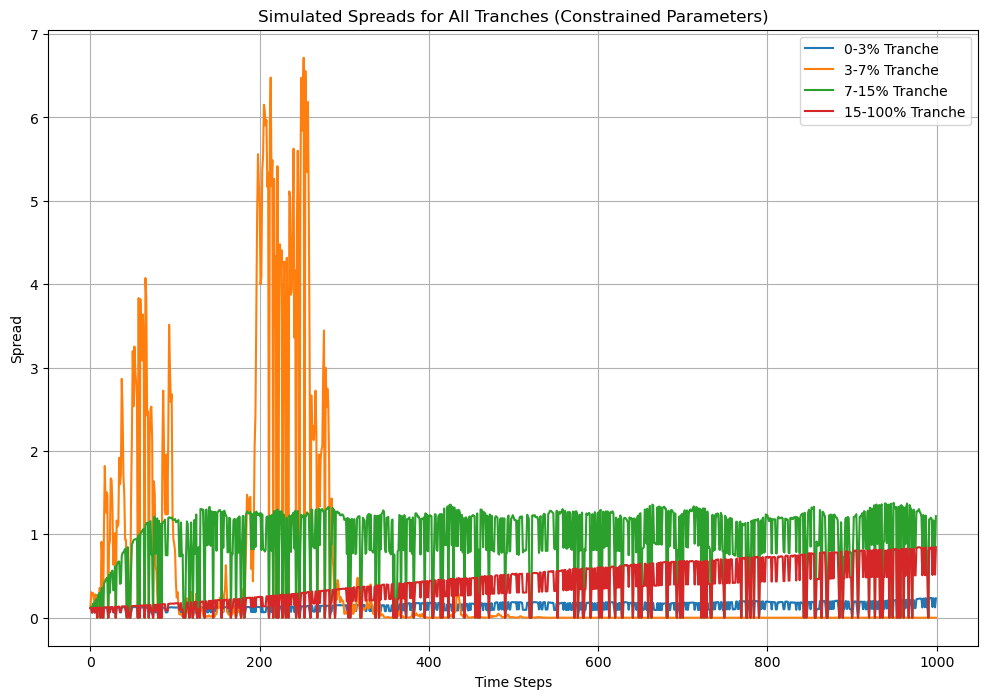

In [21]:

# Function to safely simulate Y_t
def simulate_Y_t_safe(kappa, sigma, initial_Y, time_steps, dt=1 / 252):
    """
    Simulate Y_t dynamics safely using the Euler-Maruyama method.
    Args:
        kappa (float): Mean-reversion speed.
        sigma (float): Volatility of Y_t.
        initial_Y (float): Initial value of Y_t.
        time_steps (int): Number of time steps to simulate.
        dt (float): Time step size (default: daily).
    Returns:
        np.array: Simulated Y_t values.
    """
    Y_t = np.zeros(time_steps)
    Y_t[0] = initial_Y
    
    for t in range(1, time_steps):
        dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
        arg = -kappa * np.log(max(Y_t[t - 1], 1e-6)) * dt + sigma * dW
        arg = np.clip(arg, -700, 700)  # Safe range for exponential
        Y_t[t] = max(Y_t[t - 1] * np.exp(arg), 1e-6)
    
    return Y_t

# Function to simulate spreads using log-transformed calibrated parameters
def simulate_spreads_log(Y_t, b_k, n, N_t):
    """
    Simulate tranche spreads on the log-transformed scale using Y_t and calibrated parameters.
    Args:
        Y_t (np.array): Simulated Y_t values.
        b_k (np.array): Calibrated tranche coefficients.
        n (int): Total number of entities.
        N_t (np.array): Defaults at each time step (array of length time_steps).
    Returns:
        np.array: Simulated spreads in the original scale (un-log-transformed).
    """
    log_spreads = np.array([
        np.log(Y * (n - Nt) * sum(b_k[:min(Nt, len(b_k))]) + 1) for Y, Nt in zip(Y_t, N_t)
    ])
    #original_spreads = np.exp(log_spreads) - 1
    original_spreads = log_spreads 

    return original_spreads

# Function to constrain parameters
def constrain_params(param, lower=0.01, upper=10):
    """
    Constrain parameter to a reasonable range.
    Args:
        param (float): Parameter value to constrain.
        lower (float): Minimum allowed value.
        upper (float): Maximum allowed value.
    Returns:
        float: Constrained parameter.
    """
    return np.clip(param, lower, upper)

# Function to un-log transform parameters
def unlog_transform_params(log_param):
    """
    Un-log transform a single parameter or array.
    Args:
        log_param (float or array): Log-transformed parameter(s).
    Returns:
        float or array: Un-log-transformed parameter(s).
    """
    if isinstance(log_param, (list, np.ndarray)):
        return np.maximum(np.exp(log_param) - 1, 0.01)  # Element-wise for arrays
    else:
        return max(np.exp(log_param) - 1, 0.01)  # Single scalar case

# Function to prepare un-log-transformed and constrained parameters
def prepare_unlogged_calibration_with_constraints(calibration_results):
    """
    Prepare un-log-transformed and constrained calibration results for simulation.
    Args:
        calibration_results (dict): Dictionary with calibrated log-transformed parameters.
    Returns:
        dict: Updated dictionary with un-log-transformed and constrained parameters.
    """
    unlogged_results = {}
    
    for tranche, params in calibration_results.items():
        b_k = unlog_transform_params(params['b_k'])
        kappa = constrain_params(unlog_transform_params(params['kappa']))
        sigma = constrain_params(unlog_transform_params(params['sigma']))
        
        unlogged_results[tranche] = {
            'b_k': b_k,
            'kappa': kappa,
            'sigma': sigma
        }
    
    return unlogged_results

# Function to simulate for all tranches
def simulate_all_tranches_with_log(calibration_results, time_steps, dt=1/252, initial_Y=0.05, n=125, N_t=2):
    """
    Simulate Y_t dynamics and spreads for all tranches using log-transformed parameters.
    Args:
        calibration_results (dict): Dictionary with calibrated parameters.
        time_steps (int): Number of time steps for simulation.
        dt (float): Time step size (default: daily).
        initial_Y (float): Initial value of Y_t.
        n (int): Total number of entities.
        N_t (int): Defaults at each time step.
    Returns:
        dict: Simulated results with Y_t and spreads for each tranche.
    """
    simulation_results = {}
    
    for tranche, params in calibration_results.items():
        b_k = params['b_k']
        kappa = params['kappa']
        sigma = params['sigma']
        
        # Simulate Y_t
        Y_t = simulate_Y_t_safe(kappa, sigma, initial_Y, time_steps, dt)
        
        # Simulate spreads on the log-transformed scale
        spreads = simulate_spreads_log(Y_t, b_k, n, N_t)
        
        # Store results
        simulation_results[tranche] = {
            'Y_t': Y_t,
            'spreads': spreads,
            'kappa': kappa,
            'sigma': sigma
        }
    
    return simulation_results

# Simulation parameters
#time_steps = 252  # Simulating one year (252 trading days)
#dt = 1 / 252  # Daily time step
#initial_Y = 0.05  # Starting value of Y_t
#n = 125  # Total number of entities
N_t_simulated = np.random.poisson(lam=2, size=time_steps)  # Simulate defaults dynamically

# Un-log transform parameters with constraints
unlogged_calibration_results_safe = prepare_unlogged_calibration_with_constraints(calibration_results_adjusted)

# Run simulation for all tranches
simulation_results_safe = simulate_all_tranches_with_log(
    calibration_results=unlogged_calibration_results_safe,
    time_steps=time_steps,
    dt=dt,
    initial_Y=initial_Y,
    n=n,
    N_t=N_t_simulated
)

# Plot simulated spreads for all tranches
plt.figure(figsize=(12, 8))
for tranche, results in simulation_results_safe.items():
    plt.plot(results['spreads'], label=f'{tranche} Tranche')
plt.title('Simulated Spreads for All Tranches (Constrained Parameters)')
plt.xlabel('Time Steps')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()


## STEP 5- Calculated tranche losses:

In [23]:
# Define tranche attachment/detachment points
tranche_points = {
    '0-3%': (0.0, 0.03),
    '3-7%': (0.03, 0.07),
    '7-15%': (0.07, 0.15),
    '15-100%': (0.15, 1.00)
}

# Calculate tranche weights
tranche_weights = {tranche: b - a for tranche, (a, b) in tranche_points.items()}
print("Tranche Weights:", tranche_weights)

# Aggregate portfolio losses (L_t) from tranche simulations
#time_steps = 252  # Number of time steps (example: 1 year)
#portfolio_losses = np.zeros(time_steps)
# Update time_steps to match the length of simulated Y_t
time_steps = len(next(iter(simulation_results_safe.values()))['Y_t'])  # Use length of first tranche's Y_t
portfolio_losses = np.zeros(time_steps)  # Initialize portfolio losses

# Aggregate Y_t from all tranches, weighted by tranche size
#for tranche, weight in tranche_weights.items():
#    portfolio_losses += weight * simulation_results_safe[tranche]['Y_t']

# Ensure portfolio losses are cumulative
#portfolio_losses = np.cumsum(portfolio_losses)
scaling_factor = 0.01  # Adjust to ensure realistic growth of L_t
portfolio_losses = np.cumsum([weight * scaling_factor * simulation_results_safe[tranche]['Y_t']
                              for tranche, weight in tranche_weights.items()])
# Apply smoothing to portfolio losses
smoothed_portfolio_losses = np.convolve(portfolio_losses, np.ones(10)/10, mode='same')


Tranche Weights: {'0-3%': 0.03, '3-7%': 0.04000000000000001, '7-15%': 0.07999999999999999, '15-100%': 0.85}


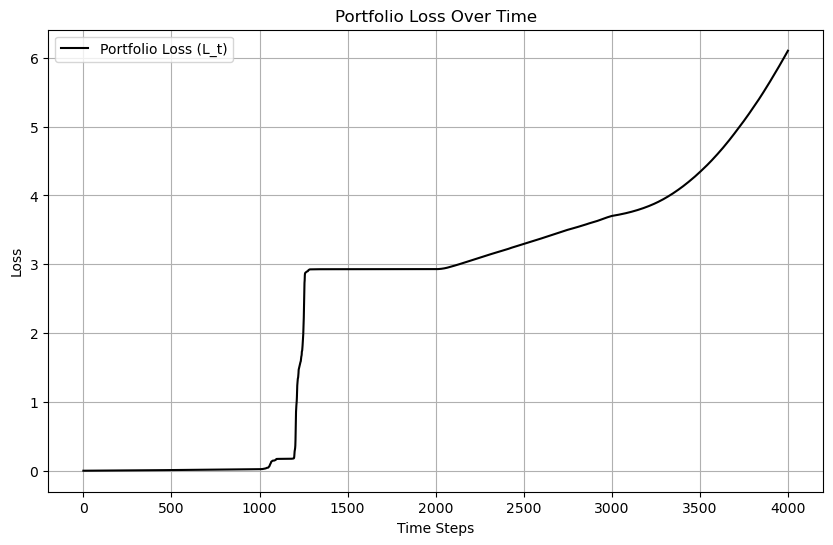

In [24]:
# Plot portfolio losses (L_t)
plt.figure(figsize=(10, 6))
plt.plot(portfolio_losses, label='Portfolio Loss (L_t)', color='black')
plt.title('Portfolio Loss Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Function to compute tranche losses
def compute_tranche_loss(portfolio_losses, a, b):
    """
    Compute tranche losses for a given tranche.
    Args:
        portfolio_losses (np.array): Array of portfolio losses (L_t) over time.
        a (float): Attachment point of the tranche.
        b (float): Detachment point of the tranche.
    Returns:
        np.array: Tranche losses (L_[a, b]) at each time step.
    """
    # Calculate tranche losses using the formula
    tranche_losses = np.maximum(portfolio_losses - a, 0) - np.maximum(portfolio_losses - b, 0)
    return tranche_losses

# Function to compute expected loss
def compute_expected_loss(tranche_losses):
    """
    Compute the expected loss for a tranche.
    Args:
        tranche_losses (np.array): Array of tranche losses.
    Returns:
        float: Expected loss over the simulation period.
    """
    return np.mean(tranche_losses)

# Compute tranche losses and expected losses for all tranches
tranche_loss_results = {}

for tranche, (a, b) in tranche_points.items():
    # Compute tranche-specific losses
    tranche_losses = compute_tranche_loss(portfolio_losses, a, b)
    expected_loss = compute_expected_loss(tranche_losses)
    
    tranche_loss_results[tranche] = {
        'tranche_losses': tranche_losses,
        'expected_loss': expected_loss
    }

# Display results
for tranche, results in tranche_loss_results.items():
    print(f"{tranche} Tranche:")
    print(f"  Expected Loss: {results['expected_loss']:.6f}")
    print()


0-3% Tranche:
  Expected Loss: 0.024971

3-7% Tranche:
  Expected Loss: 0.029520

7-15% Tranche:
  Expected Loss: 0.058705

15-100% Tranche:
  Expected Loss: 0.594639



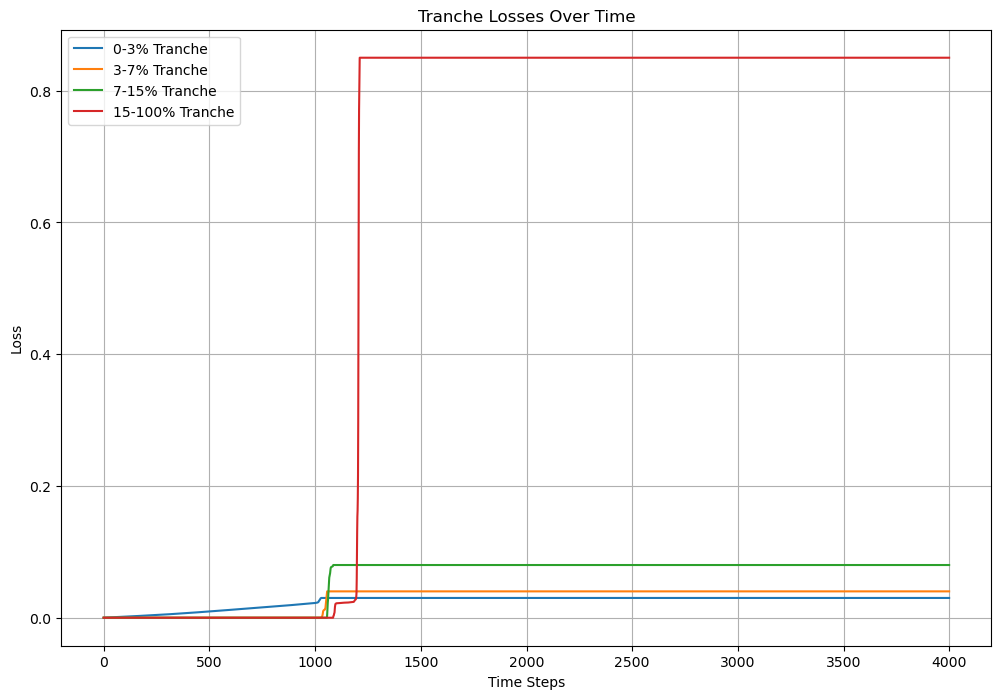

In [26]:
# Plot tranche losses over time
plt.figure(figsize=(12, 8))
for tranche, results in tranche_loss_results.items():
    plt.plot(results['tranche_losses'], label=f'{tranche} Tranche')
plt.title('Tranche Losses Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## STEP 6- EVALUATE 

In [27]:
# Extract and preprocess real tranche data
real_tranche_data = cleaned_tranche_data.copy()
real_tranche_data_processed = {}

    
# Align simulated losses to real tranche data length
real_tranche_data_processed = {}

for tranche, data in real_tranche_data.items():
    # Select the 'Spread' column and drop NaN values
    real_spreads = data['Spread'].dropna().values

    # Truncate simulated losses to match real data length
    simulated_losses = tranche_loss_results[tranche]['tranche_losses'][:len(real_spreads)]
    
    # Store aligned real and simulated data
    real_tranche_data_processed[tranche] = real_spreads
    tranche_loss_results[tranche]['tranche_losses'] = simulated_losses


In [28]:
from sklearn.metrics import mean_squared_error
import math

In [29]:
# Adjust simulations for vol.
# Add real volatility to simulated tranche losses
adjusted_simulation_results = {}

for tranche, real_volatility in real_volatility_data.items():
    simulated_losses = tranche_loss_results[tranche]['tranche_losses']
    
    # Scale volatility to match simulated loss scale
    scaled_volatility = real_volatility[:len(simulated_losses)] * 0.01  # Adjust scaling factor
    
    # Add volatility to simulated losses
    adjusted_losses = simulated_losses + np.random.normal(0, scaled_volatility, len(simulated_losses))
    
    # Store adjusted results
    adjusted_simulation_results[tranche] = adjusted_losses


In [32]:
# evaluate simul with vol.
# Evaluate adjusted simulation results
evaluation_results_adjusted = {}

for tranche, real_spreads in real_tranche_data_processed.items():
    # Adjusted simulated losses
    adjusted_losses = adjusted_simulation_results[tranche]
    
    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(real_spreads, adjusted_losses))
    
    # Calculate volatility reduction
    real_volatility = np.std(real_spreads)
    adjusted_volatility = np.std(adjusted_losses)
    volatility_reduction = (1 - adjusted_volatility / real_volatility) * 100
    
    # Store results
    evaluation_results_adjusted[tranche] = {
        'RMSE': rmse,
        'Real Volatility': real_volatility,
        'Adjusted Volatility': adjusted_volatility,
        'Volatility Reduction (%)': volatility_reduction
    }

# Display adjusted evaluation results
for tranche, metrics in evaluation_results_adjusted.items():
    print(f"{tranche} Tranche Evaluation (Adjusted):")
    print(f"  RMSE: {metrics['RMSE']:.6f}")
    #print(f"  Real Volatility: {metrics['Real Volatility']:.6f}")
    #print(f"  Adjusted Volatility: {metrics['Adjusted Volatility']:.6f}")
    #print(f"  Volatility Reduction: {metrics['Volatility Reduction (%)']:.2f}%")
    print()


0-3% Tranche Evaluation (Adjusted):
  RMSE: 17.948665

3-7% Tranche Evaluation (Adjusted):
  RMSE: 0.581556

7-15% Tranche Evaluation (Adjusted):
  RMSE: 2.096885

15-100% Tranche Evaluation (Adjusted):
  RMSE: 2.860482

